In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import osmnx as ox
from functools import partial
import numpy as np
import pandas as pd
from multiprocessing import Pool,cpu_count
import matplotlib.pyplot as plt
import networkx as nx
import geopandas as gpd
from shapely.geometry import MultiLineString,MultiPoint,Point,LineString,MultiPolygon
from shapely import wkt
from shapely.ops import nearest_points
import glob
import time
import gpxpy
from itertools import groupby
import random
import sklearn
from mlinsights.mlmodel import PiecewiseRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from scipy.signal import savgol_filter
from lib_garmin_elevation import *

0.049361228942871094


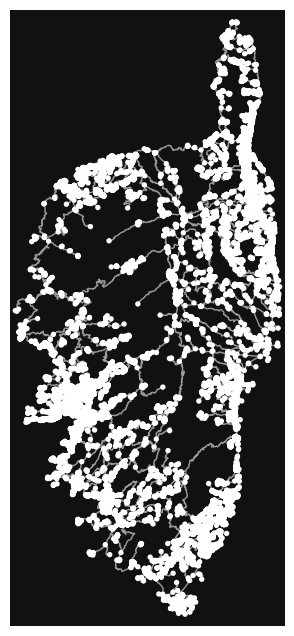

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [2]:
place_name='Corse, France'
G_osm=ox.graph_from_place(place_name,network_type='drive')
G_osm=to_multi_graph(G_osm)
crs=ox.graph_to_gdfs(G_osm,edges=False).estimate_utm_crs()
G_osm=ox.project_graph(G_osm,to_crs=crs)
t1=time.time()
add_missing_geometries(G_osm)
t2=time.time()
print(t2-t1)

ox.plot_graph(G_osm)


In [3]:
def parallelized_preprocess(file_paths):
    garmin_dfs=[preprocess(file_path,G_osm,crs=crs) for file_path in file_paths]
    return pd.concat(garmin_dfs)

In [4]:
GENERATE=True
navigation_df_path='/home/pierre/Documents/navigation_df.csv'
if GENERATE:
    t1=time.time()
    nb_cpu=cpu_count()-1
    file_paths=glob.glob('/home/pierre/Documents/garmin_corse/*.gpx')
    chunked_file_paths=chunk(file_paths,nb_cpu)
    with Pool(nb_cpu) as p:
        navigation_dfs=p.map(parallelized_preprocess,chunked_file_paths)
    navigation_df=pd.concat(navigation_dfs)
    navigation_df=navigation_df.to_crs('epsg:4326')
    navigation_df.to_csv(navigation_df_path,index=False)
    navigation_df=navigation_df.to_crs(crs)
    t2=time.time()
    print(t2-t1)
else:
    navigation_df=pd.read_csv(navigation_df_path)
    navigation_df['geometry']=navigation_df['geometry'].apply(wkt.loads)
    navigation_df=gpd.GeoDataFrame(navigation_df,geometry='geometry',crs='epsg:4326')
    navigation_df['time']=pd.to_datetime(navigation_df['time'])
    navigation_df['edge']=navigation_df['edge'].apply(eval)
    navigation_df=navigation_df.to_crs(crs)
navigation_df

reading file took 0.693593 s
estimating crs took 0.015556 s
reading file took 1.190625 s
estimating crs took 0.017615 s
reading file took 1.249044 s
estimating crs took 0.023772 s
reading file took 1.281819 s
estimating crs took 0.041821 s
reading file took 2.596754 s
estimating crs took 0.031668 s
reading file took 2.728675 s
estimating crs took 0.035878 s
projecting took  2.117026 s
reading file took 2.836415 s
estimating crs took 0.065281 s
projecting took  1.758229 s
adding segments took 0.233894 s
projecting took  1.809444 s
projecting took  2.080276 s
adding segments took 0.377901 s
adding segments took 0.562855 s
reading file took 0.113305 s
estimating crs took 0.021538 s
adding segments took 0.305026 s
reading file took 1.047785 s
estimating crs took 0.016761 s
reading file took 0.560830 s
estimating crs took 0.015484 s
projecting took  0.795367 s
adding segments took 0.221442 s
reading file took 0.623873 s
estimating crs took 0.014179 s
projecting took  1.356025 s
projecting t

NameError: name 'garmin_df_path' is not defined

In [5]:
plt.rcParams['figure.figsize']=(20,20)
t1=time.time()
G_navigation=build_multidigraph(G_osm,navigation_df)
t2=time.time()
print(t2-t1)


6.108269929885864


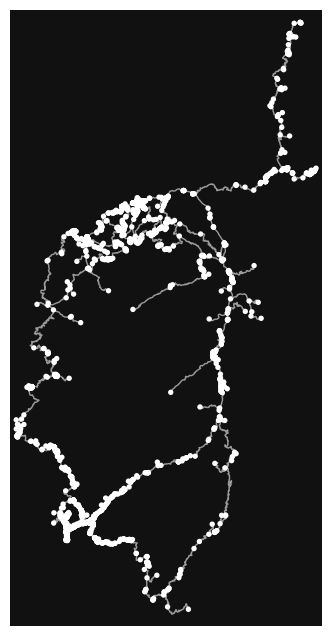

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [80]:
edges=sorted(navigation_df['edge'].unique(),key=lambda edge:G_osm.get_edge_data(*edge)['length'])
ox.plot_graph(nx.edge_subgraph(G_osm,edges))

0.00019478797912597656


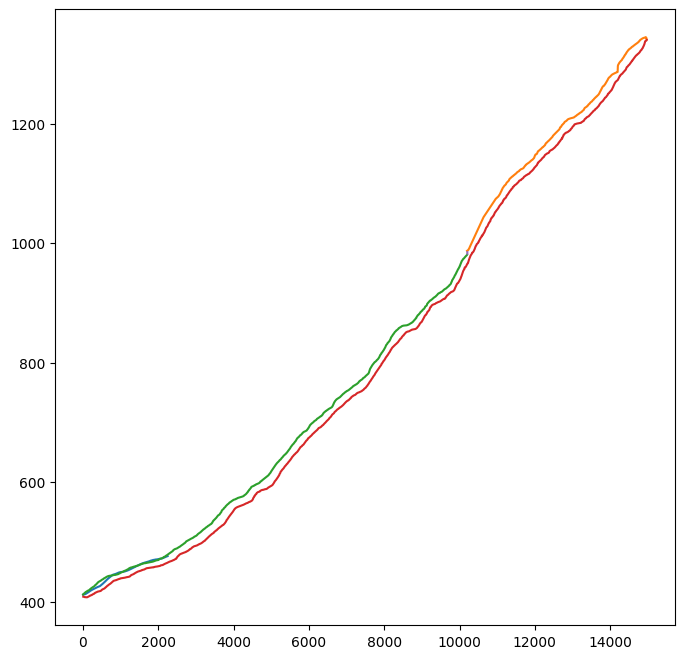

In [94]:
plt.rcParams['figure.figsize']=(8,8)
edge=edges[-6]
path=[edge]

t1=time.time()
meta_segments,_=get_meta_segments_along_path(path,G_navigation,G_osm)
t2=time.time()
print(t2-t1)
for elem in meta_segments:
    X,Y=elem['X'],elem['Y']
    plt.plot(X,Y)
    #plt.scatter(X[0],Y[0],c='g')
    #plt.scatter(X[-1],Y[-1],c='r')


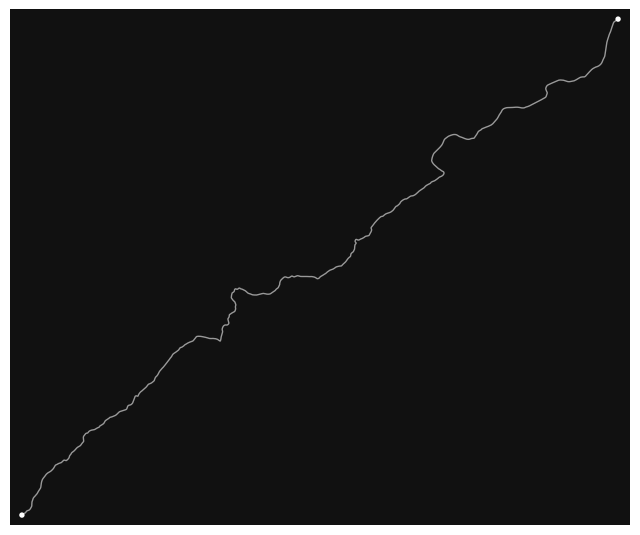

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [95]:
ox.plot_graph(nx.edge_subgraph(G_osm,map(tuple,path[:])))

0.017615795135498047 0.5258855819702148


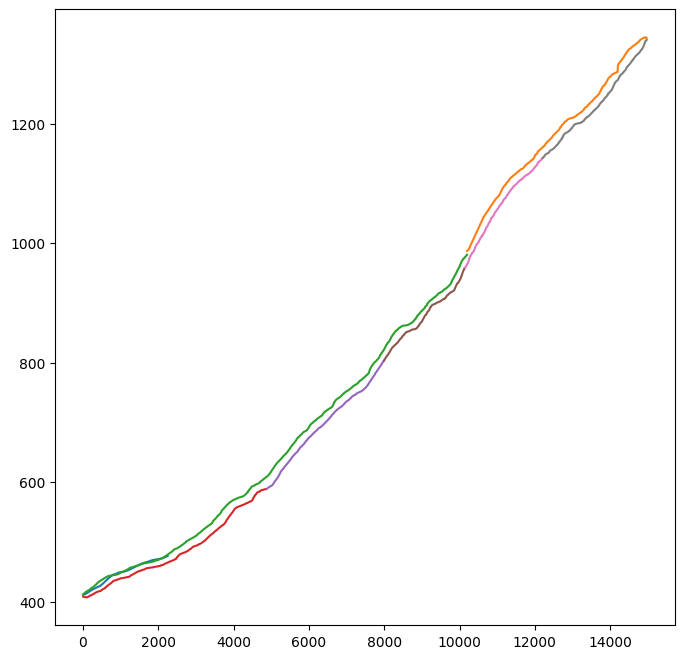

In [96]:
plt.rcParams['figure.figsize']=(8,8)
t1=time.time()
meta_segments=split_meta_segments(meta_segments,max_delta_T=900)
meta_segments=harmonize_meta_segments(meta_segments)
meta_segments=discard_outliers(meta_segments)
t2=time.time()
pairwise_shifts,affine_meta_segments=get_pairwise_shifts(meta_segments,overlay_threshold=0.25,)
t3=time.time()
print(t3-t2,t2-t1)
for meta_segment in meta_segments:
    plt.plot(meta_segment['X'],meta_segment['Y'])
for k in affine_meta_segments:
    meta_segment=meta_segments[k]
    plt.plot(meta_segment['X'],meta_segment['Y'],c='k')    

0.000125885009765625


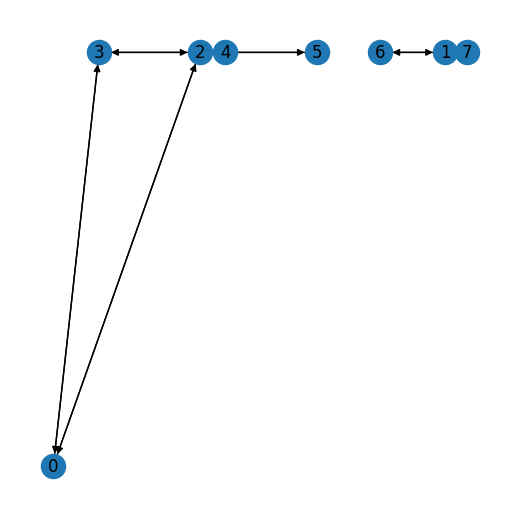

In [97]:
plt.rcParams['figure.figsize']=(5,5)

file_paths=list(np.unique(navigation_df['file_path']))
N=len(meta_segments)
t1=time.time()
shift_G=get_shifts_graph(pairwise_shifts,correlation_treshold=0.99)
t2=time.time()
print(t2-t1)

pos={k:(np.mean(meta_segments[k]['X']),file_paths.index(meta_segments[k]['file_path'])) for k in range(N)} 
nx.draw(shift_G,pos=pos,with_labels=True)

0.0003886222839355469


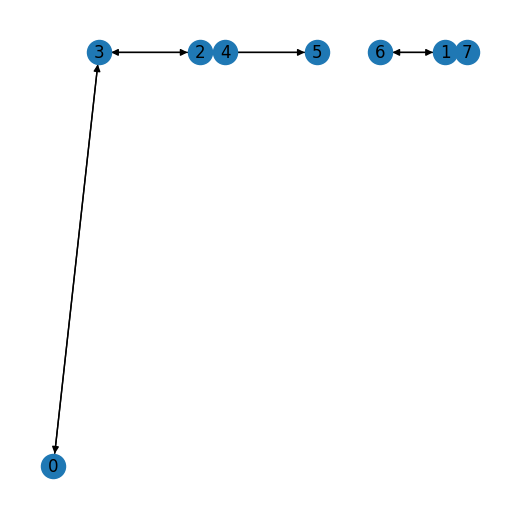

In [98]:
t1=time.time()
tree_edges=list(nx.minimum_spanning_edges(nx.Graph(shift_G),weight='weight',data=False))
tree_edges+=[(v,u) for u,v in tree_edges]
shift_tree=nx.edge_subgraph(shift_G,tree_edges)
t2=time.time()
print(t2-t1)
nx.draw(shift_tree,pos=pos,with_labels=True)

0.0008053779602050781


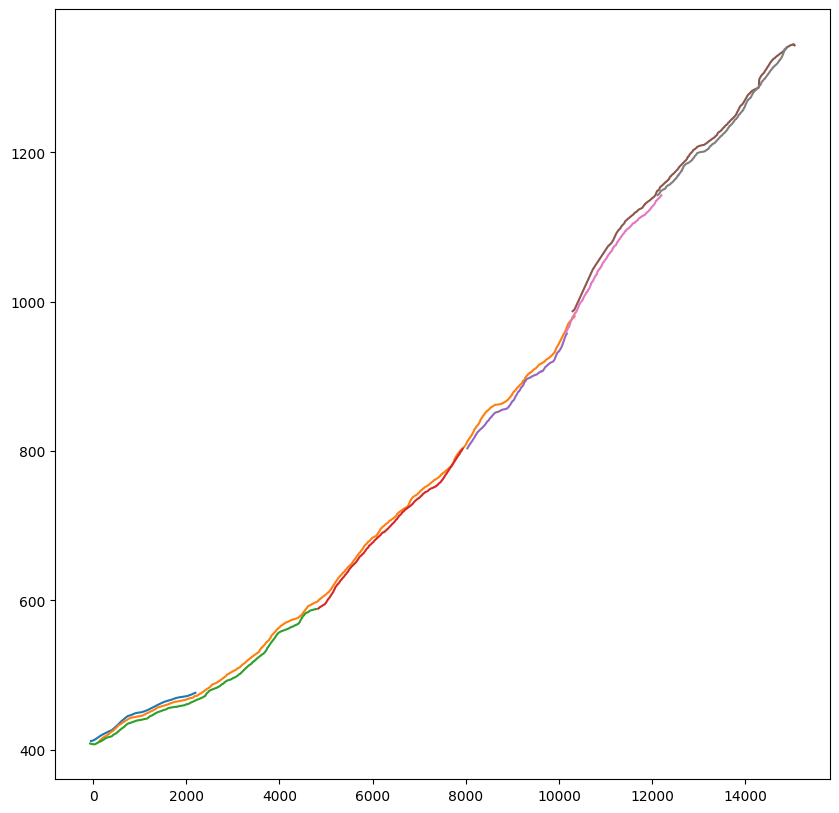

In [99]:
plt.rcParams['figure.figsize']=(10,10)
t1=time.time()
corrected_meta_segments=realign_meta_segments_from_tree(shift_tree,meta_segments,min_components=1)
corrected_meta_segments+=[meta_segments[k] for k in affine_meta_segments]
t2=time.time()
print(t2-t1)
for meta_segment in corrected_meta_segments:
    plt.plot(meta_segment['X'],meta_segment['Y'])



In [25]:
cover,extremities=get_cover(corrected_slopes,min_count=2)

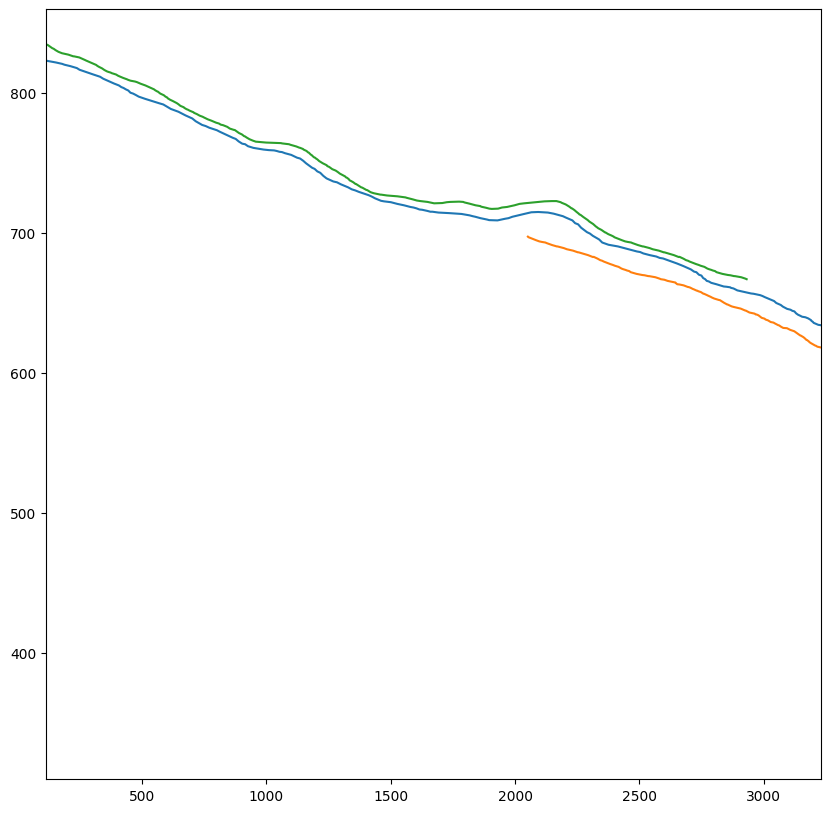

In [26]:
i=0
sub_slopes=[corrected_slopes[k] for k in cover[i]]
x_min,x_max=extremities[i]
plt.xlim(x_min,x_max)
for slope in sub_slopes:
    plt.plot(slope['X'],slope['Y'])    


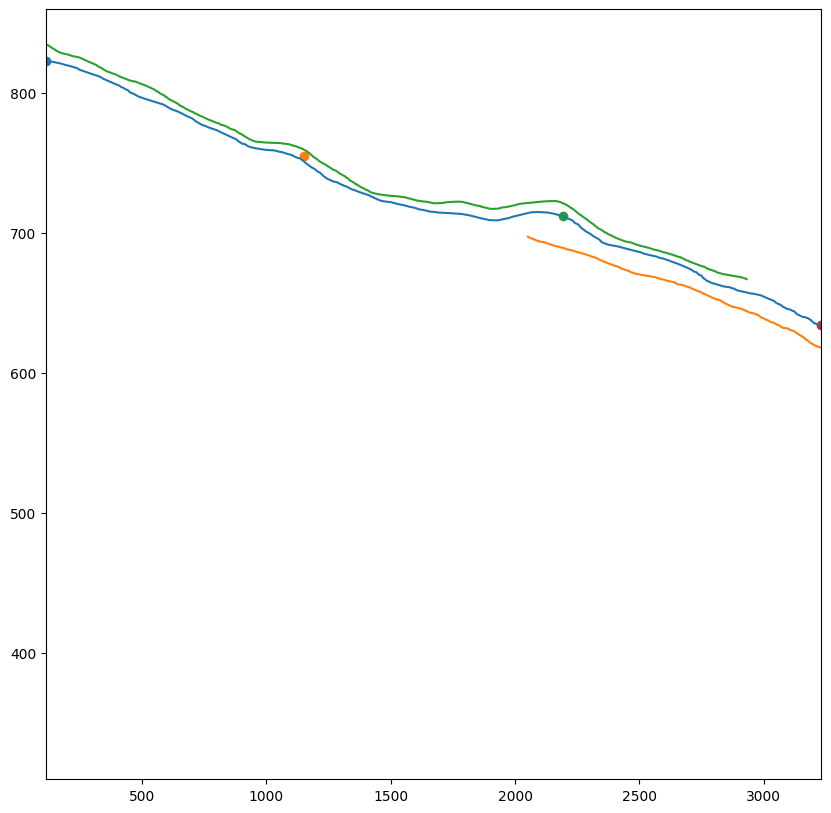

In [27]:
plt.xlim(x_min,x_max)
intermediate_distance=1000
intermediate_points=np.linspace(x_min,x_max,max(round((x_max-x_min)/intermediate_distance)+1,2))
for slope in sub_slopes:
    plt.plot(slope['X'],slope['Y']) 
intermediate_elevations=get_intermediate_elevation(intermediate_points,sub_slopes)
for k,l in enumerate(intermediate_elevations):
    plt.scatter(intermediate_points[k],np.nanmedian(l))

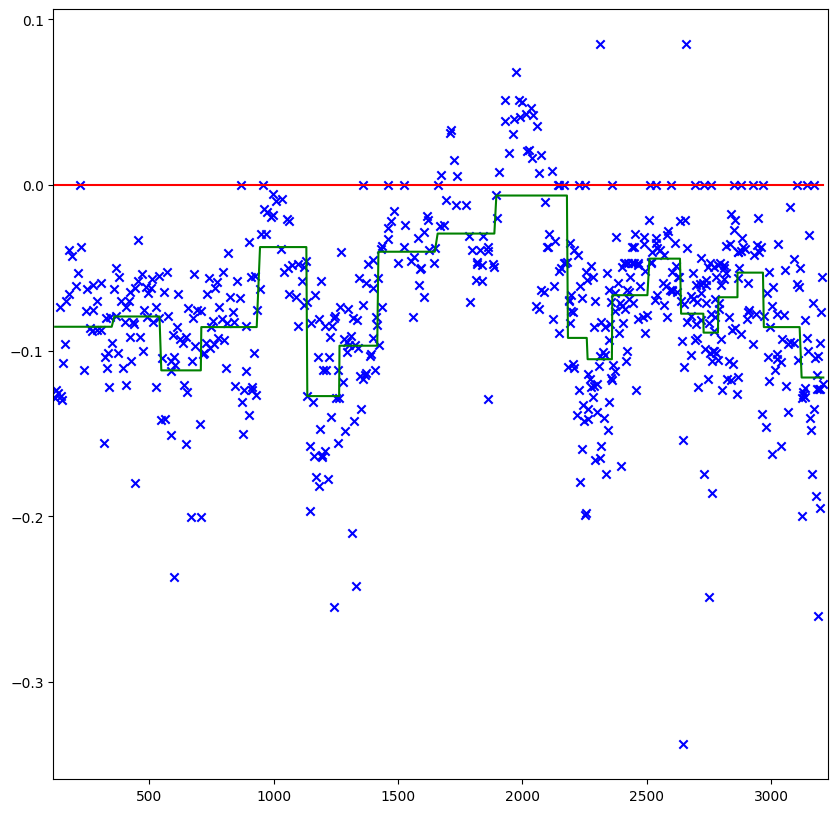

In [28]:
plt.xlim(x_min,x_max)
output=approximate_derivative(sub_slopes,x_min=x_min,x_max=x_max,
                                    min_samples_leaf=25,min_impurity_decrease=0.5*float('1e-6'))
if output is not None:
    X,dYdX,model=output
    Z=model.predict(X.reshape(-1,1))
    plt.scatter(X,dYdX,c='b',marker='x')
    plt.plot([0,X[-1]],[0,0],c='r')
    plt.plot(X,Z,c='g')


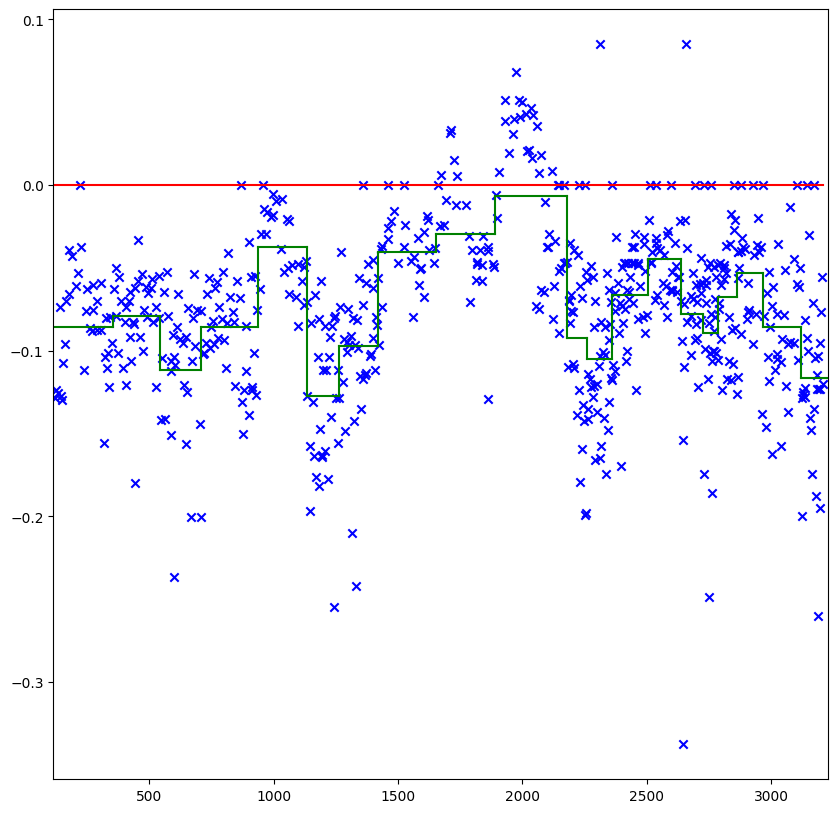

In [29]:
plt.xlim(x_min,x_max)
intervals=simplify_tree(model.tree_,x_min,x_max,min_interval=100.)
plt.scatter(X,dYdX,c='b',marker='x')
plt.plot([0,X[-1]],[0,0],c='r')
for x1,x2,v in intervals:
    plt.plot([x1,x2],[v,v],c='g')
for k in range(len(intervals)-1):
    _,x1,v1=intervals[k]
    x2,_,v2=intervals[k+1]
    plt.plot([x1,x2],[v1,v2],c='g')

-23.975443 m elevation difference on a 3.115474 kms long path


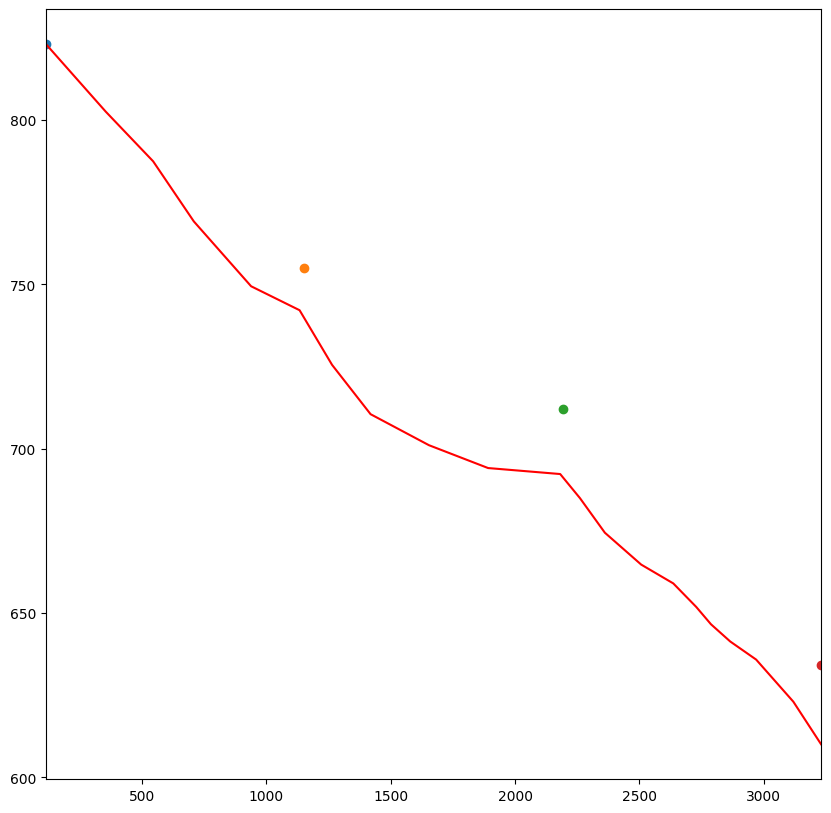

In [30]:
plt.xlim(x_min,x_max)
XX,YY=infer_curve_from_estimated_gradient(intervals,np.nanmedian(intermediate_elevations[0]))

plt.plot(XX,YY,c='r')
for k,l in enumerate(intermediate_elevations):
    plt.scatter(intermediate_points[k],np.nanmedian(l))
print('%f m elevation difference on a %f kms long path'%(YY[-1]-np.nanmedian(intermediate_elevations[-1]),(x_max-x_min)/1000))

total error 23.975443:


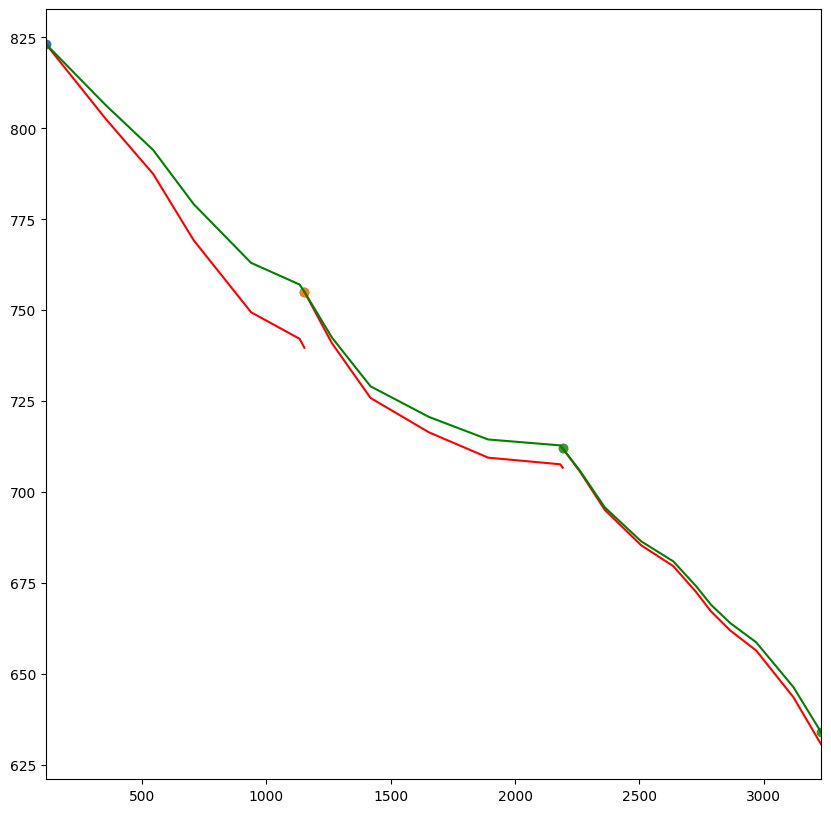

In [32]:
plt.xlim(x_min,x_max)
s=0
for k in range(len(intermediate_points)-1):
    sub_intervals=[[min(max(x1,intermediate_points[k]),intermediate_points[k+1]),min(max(x2,intermediate_points[k]),intermediate_points[k+1]),v] for x1,x2,v in intervals if x2>=intermediate_points[k] and x1<=intermediate_points[k+1]]
    XX,YY=infer_curve_from_estimated_gradient(sub_intervals,np.nanmedian(intermediate_elevations[k]))
    plt.plot(XX,YY,c='r')
    delta_expected=np.nanmedian(intermediate_elevations[k+1])-np.nanmedian(intermediate_elevations[k])
    YY,delta=adjust_curve_elevation(YY,delta_expected)
    s+=abs(delta-delta_expected)
    plt.plot(XX,YY,c='g')

    
    plt.scatter([intermediate_points[k],intermediate_points[k+1]],[np.nanmedian(intermediate_elevations[k]),np.nanmedian(intermediate_elevations[k+1])])
print('total error %f:'%s)

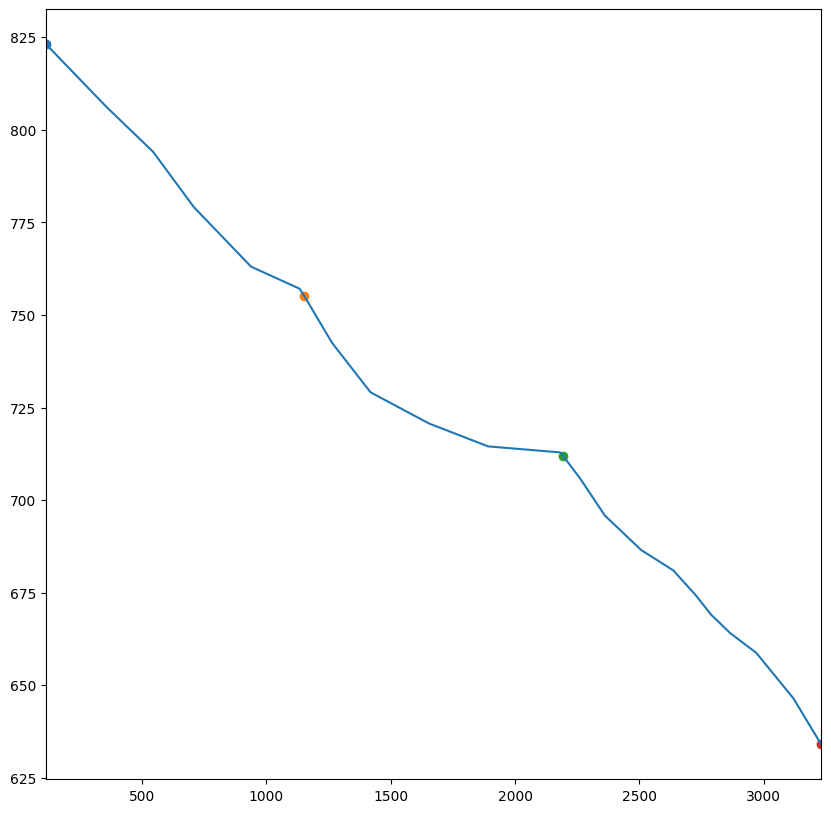

In [33]:
plt.xlim(x_min,x_max)
X,Y=approximate_slope(sub_slopes,x_min,x_max,intermediate_distance=1000)
X,Y=np.array(X),np.array(Y)
plt.plot(X,Y)
for k,l in enumerate(intermediate_elevations):
    plt.scatter(intermediate_points[k],np.nanmedian(l))
    
